<a href="https://colab.research.google.com/github/MandeepKharb/Youtube/blob/main/CorrectiveRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Corrective-RAG (CRAG)** is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

The paper ( https://arxiv.org/abs/2401.15884) follows this general flow:


  * If at least one document exceeds the threshold for relevance, then it proceeds to generation.
  * If all documents fall below the relevance threshold or if the grader is unsure, then it uses web search to supplement retrieval.
  * Before generation, it performs knowledge refinement of the search or retrieved documents.
  * This partitions the document into knowledge strips.
  * It grades each strip, and filters out irrelevant ones



**We will implement some of these ideas from scratch using LangGraph:**

* If any documents are irrelevant, we'll supplement retrieval with web search.
* We'll skip the knowledge refinement, but this can be added back as a node if desired.
* We'll use Tavily Search for web search.

In [37]:
%pip install -U langchain_community tiktoken langchainhub scikit-learn langchain langgraph tavily-python  nomic[local] langchain-nomic langchain_openai langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [38]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
os.environ["TAVILY_API_KEY"]=getpass.getpass()

··········
··········


**Create Index**

In [39]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings  # local


# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/"
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Embedding

embedding=NomicEmbeddings(
    model="nomic-embed-text-v1.5",
    inference_mode="local",
)


# Add the document chunks to the "vector store"
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

In [40]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain_groq import ChatGroq

In [43]:
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser


# LLM
llm = ChatGroq(model="llama3-8b-8192",temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given:
    1/ a QUESTION
    2/ A FACT provided by the student

    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION.
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION.
    1 is the highest (best) score. 0 is the lowest score you can give.

    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct.

    Avoid simply stating the correct answer at the outset.

    Question: {question} \n
    Fact: \n\n {documents} \n\n

    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    Strictly make sure that value of key 'score' could be either 'yes' or 'no', nothing else
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | StrOutputParser()
question = "What are the types of agent memory?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

To grade the relevance of the fact to the question, I will follow the steps:

1. Read the question: "What are the types of agent memory?"
2. Read the fact: "Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language."

Step-by-step analysis:

* The question asks about the types of agent memory.
* The fact mentions a specific type of agent memory, which is the "Memory stream".
* The fact describes the Memory stream as a long-term memory module that records agents' experience in natural language.

Conclusion:

The fact is relevant to the question because it specifically mentions a type of agent memory, which is the "Memory stream". Therefore, I will give a score of:

{"score": "yes"}


In [44]:
# ### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.

    Use the following documents to answer the question.

    If you don't know the answer, just say that you don't know.

    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Documents: {documents}
    Answer:
    """,
    input_variables=["question", "documents"],
)



# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

According to the documents, there are three types of agent memory mentioned:

1. Short-term memory: This is used for in-context learning and is short and finite, restricted by the finite context window length of the Transformer.
2. Long-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.
3. Sensory memory: This is used to acquire, store, retain, and later retrieve sensory information, such as visual, auditory, or touch impressions.

Note that these types of memory are mentioned in different documents, and there might be other types of memory mentioned in other sources.


In [46]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

**Create the Graph**

In [47]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph
import json


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]




**Retrieve** **Node**

In [48]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}

**Generate Node**

In [49]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

**Grade Documents**

In [50]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for i, d in enumerate(documents):
        resp = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        print("here is the Raw response:", resp)

        if '"score": "yes"' in resp:
            filtered_docs.append(d)
        elif i == len(documents) - 1 and search == "No":
            search = "Yes"
            continue
    print('value of search is :',search )
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


**Web Search Node**

In [52]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}

**Generation Decision**

In [53]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

**Build Graph**

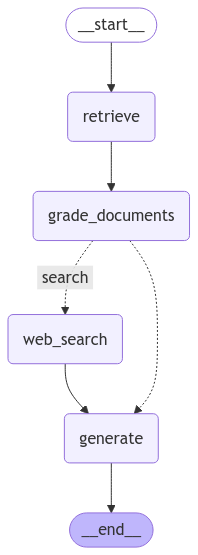

In [61]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [63]:
import uuid


def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "who is sachin tendulkar ?"}
response = predict_custom_agent_local_answer(example)
response

here is the Raw response: To grade the relevance of the fact to the question, I will follow the steps:

1. Read the question: "Who is Sachin Tendulkar?"
2. Read the fact: The fact is about LLM-based evaluation, ChemCrow, GPT-4, and scientific discovery. There is no mention of Sachin Tendulkar.

Conclusion: None of the statements in the fact are relevant to the question. The fact is about AI, scientific discovery, and evaluation, whereas the question is about a person, Sachin Tendulkar.

JSON score:
{
"score": "no"
}
here is the Raw response: Let's break down the fact and question step by step:

1. The question is "who is sachin tendulkar?"
2. The fact provides two unrelated pieces of information:
	* A picture of a sea otter using a rock to crack open a seashell, which is about animal behavior and tool use.
	* A description of a neuro-symbolic architecture called MRKL, which is about artificial intelligence and computer science.

Neither of these pieces of information has any relevance 

{'response': 'Sachin Ramesh Tendulkar is a former cricketer and captain of the Indian team, considered one of the greatest batsmen of all time. He has set many records in his career, including being the only player to score over 30,000 runs in international cricket. Tendulkar is also known as "The Little Master" and "God of Cricket".',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}